# What Do People Want To Learn About in Data Science?

### Introduction

We are working for a company that creates data science content, be it books, online articles, videos or interactive text-based platforms like Dataquest.

** We are given a taks of figuring out what is that people are most interested in learning in Data Science and  what is the best content to write about.**

We decided to investigate Stack Overflow for possible answers. Doing so we find out that Stack Overflow is part of a question and answer website network called Stack Exchange.

ack Exchange hosts sites on a multitude of fields and subjects, including mathematics, physics, philosophy, and data science! Here's a sample of the most popular sites:

In [177]:
from IPython.display import Image
Image(url="https://dq-content.s3.amazonaws.com/469/se_sites.png", height=970, width=530)


Stack Exchange employs a reputation award system for its questions and answers. Each post — each question/answer — is a post that is subject to upvotes and downvotes. This ensures that good posts are easily identifiable.
Luckyli for us there is a site in Stack Exchanged called  [Data Science Stack Exchange](https://datascience.stackexchange.com) (DSSE), it is a data science dedicated site (contrarily to the others), coupled with it having a lot of unanswered questions, makes it an ideal candidate for this investigation. DSSE will be the focus of this guided project.

### Data Science Stack Exchange

Data Science webpage is divided into following sections:
* Home - Homepage of the site
* Questions - List of all the questions that were asked, with lots of sorting options available
* Tags - short keywords (labeled light blues squares) used to categorize the content
* Users - all the user active on the website withe links to their profiles
* Unanswered - list of all questions that are still unanswered


### Getting the Data

Stack Exchange provides a public data base for each of its websites. [Here's](https://data.stackexchange.com/datascience/query/new) a link to query and explore Data Science Stack Exchange's database.
Looking at the Stack Exchange Data Explorer (SEDE) we see there are total of 29 databases from the database schema. Below is a screenshot witth some of the names of the tables:
![Image](https://dq-content.s3.amazonaws.com/469/dsde.png)

Following tables might be of use to our project:
* Posts - data on all posts, icluding questions and answers
* Comments - cointains data on all comments, both on questions and answer posts
* Tags - data on every tag that is used on a post

We will start with the Posts table, as it contains a lot of columns, following shoud be relevant to what we are seeking:

* Id: An identification number for the post.
* PostTypeId: An identification number for the type of post.
* CreationDate: The date and time of creation of the post.
* Score: The post's score.
* ViewCount: How many times the post was viewed.
* Tags: What tags were used.
* AnswerCount: How many answers the question got (only applicable to question posts).
* FavoriteCount: How many times the question was favored (only applicable to question posts).

PostTypeId has following identification number for the type of post:

![Image](https://dq-content.s3.amazonaws.com/469/PostTypes.png)

There are eight different types of post, and before we figure out which are relevant to us, let's check how many of them there are:



In [178]:
SELECT PostTypeId, COUNT(*) AS NrOfPosts
FROM Posts
GROUP BY PostTypeId
ORDER BY PostTypeId;


SyntaxError: invalid syntax (<ipython-input-178-8994127c92a1>, line 1)

* PUT TABLE from above query

As seen from the table above, anything different from questions or answers is mostly inconsequential. Even if it happens to be the case that such kind of posts is immensely popular, they would just be outliers and not relevant to us. We'll then just focus on the questions.

Since we're only interested in recent posts, we'll limit our analysis to the posts of 2019. (At the time of writing it is early 2020).
We will run the below query against the SEDE DSSE database that extracts the columns listed above for all the questions in 2019.

In [ ]:
SELECT Id, PostTypeId, CreationDate, 
       Score, ViewCount, Tags, AnswerCount, FavoriteCount
FROM Posts
WHERE PostTypeId = 1 AND CreationDate LIKE '%2019%'
ORDER BY CreationDate;

* PUT TABLE from above query

### Exploring the Data

Data from the query was stored in a file called 2019_quesitons.csv

In [179]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

%matplotlib inline

In [180]:
questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


Running the `questions.info()` gives info on number of row and column types and names. As seen all columns are fully populated except the `FavoriteCount` which is missing significant number of rows. A missing value on this column would mean that the question was not put in any of users' favorite list. Thus, we will replace missing values with 0

In [ ]:
questions.sample(5)

In [ ]:
questions["Tags"].apply(lambda value: type(value)).unique()

Tags column shows that all values are strings, however, we will clean theese into something more readable.

### Cleaning the Data

We will stard by filling in the missing values in the FavoriteCount column


In [ ]:
questions["FavoriteCount"].value_counts()

In [ ]:
questions["FavoriteCount"] = questions["FavoriteCount"].fillna(0).astype(int)
questions["FavoriteCount"].value_counts()
questions.head()

The values in the Tags column are strings that look like this:

`<machine-learning><regression><linear-regression><regularization>"
</regularization></linear-regression></regression></machine-learning>`


We'll want to transform this string in something more suitable to use typical string methods. Our goal will be to transform strings like the above in something like:

`"machine-learning,regression,linear-regression,regularization"`

In [ ]:
questions["Tags"].head()

In [ ]:
questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")
questions.head(2)

### Most Used and Most Viewed

We now focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

We could take into account the score, or whether or not a question is part of someone's favorite questions. These are all reasonable options to investigate; but we'll limit the focus of our research to counts and views for now.

In [ ]:
#Counting the tags
tag_counts = {}

for tags in questions["Tags"]:
    for tag in tags:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

We will transform the dictonary into a DataFrame for easier readability and we will sort it by the number of `Count`

In [ ]:
tag_counts = pd.DataFrame.from_dict(tag_counts, orient="index")
tag_counts.rename(columns={0: "Count"}, inplace=True)

most_used = tag_counts.sort_values(by="Count").tail(20)
most_used

Limiting the threshold of top 20 tags that were used is somewhat limiting, however, looking at the spread among these tags indicates that popularity is high in comparison with the rest of the tags. Below we will visualize this data. 

In [ ]:
most_used.plot(kind="barh", color="purple", figsize=(10,5))

As seen, the tags used are very broad, there are some tags which are unlikely to be useful, e.g.: `dataset`, `r`, `clustering` etc... Before investigating these further, we will use the same method to get the data for the views of every single tag used.



In [ ]:
#Counting the tag views

tag_view_counts = {}

for tags, row in questions.iterrows():
    for tag in row["Tags"]:
        if tag in tag_view_counts:
            tag_view_counts[tag] += row["ViewCount"]
        else:
            tag_view_counts[tag] = row["ViewCount"]
            


In [ ]:
tag_view_counts = pd.DataFrame.from_dict(tag_view_counts, orient="index")
tag_view_counts.rename(columns={0:"ViewCount"}, inplace=True)
most_viewed = tag_view_counts.sort_values(by="ViewCount").tail(20)
most_viewed.head()

In [ ]:
most_viewed.plot(kind="barh", color="purple", figsize=(10,5))

Now, let's plot these two graphs together.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

### Relations Between Tags

We now have two dataframes - `most_used` and `most_viewed`
* `most_used` is a dataframe that counts how many times each of the top 20 tags was used.
* `most_viewed` is a dataframe that counts how many times each of the top 20 tags was viewed. Looking at the results from the last exercise, we see that most top tags are present in both dataframes.

Let's see what tags are in most_used, but not in most_viewed. We can identify them by the missing values in ViewCount below.

In [ ]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_used.head(10)

Similarly, we can see which tags are in most viewed but not in most used:

In [ ]:
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)
in_viewed.head(10)

In [ ]:
questions["Tags"].head()

We can further examine the relationship between tags, when we looked at the DSSE site earlier we saw that muptile tag are being used for each post or question.

For instance, looking at the graph of most-viewed tags, we know that pandas and numpy are both Python libraries and so will likely be used with the python tag. These libraries are commonly used in machine learning this it is likely to see Python, Pandas and Numpy used in relations where we have mahcine learning tag.
We will created an empty dataframe and populate it with the unique tags.

For our new dataframe we will use the most used tags as most of the other tags have been used a few times, and we want to look at the most relevant ones.

In [ ]:
most_used_tags = list(most_used.index)
tag_relations = pd.DataFrame(index=most_used_tags, columns=most_used_tags)
tag_relations

The dataframe that we created is quite large, and in order to make things easier for the human eye to understand, we will create a heatmap with just the most popular tas from `most_used`.

In [ ]:
tags = tag_counts
tags = list(tags.index)

relation = pd.DataFrame(index=tags, columns=tags)
relation = relation.fillna(0)

In [ ]:
for tags in questions["Tags"]:
    relation.loc[tags, tags] += 1
    
most = list(most_used.index)
test = relation.loc[most, most]
test

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(test, cmap="Greens", annot=False)

The heatmap created, reveals strong relationship between the most used tags and this is also represented by the dark green concentration in the bottom right corner.

These relationships could just coincidental if we take `pandas` and `python` tag for instance. It is common to use pandas library while working on Data Science or Machine Learning projects and it is natural to use Python for writing the code. Thus, sometimes we might not be able to extract value from these relationships.

However, looking at most used tags, we see that questions and respective tags are mainly revolving around AI, Machine Learning, Deep Learning and Python. These seem to be the areas of Data Science that are of major interest.

### Domain Knowledge

Analytical approach is not necessary needed or is even not the best way to tackle a problem. This is where Domai Knowledge comes in and where it can be very useful.

In [ ]:
most_used_tags = pd.merge(left=most_used, right=most_viewed, how="inner", left_index=True, right_index=True)
most_used_tags.sort_values("Count", ascending=False).head(10)


We noticed that the most used tags are also the most viewed. From the top 10 tags of each, here's a list of the tags in common: python, machine-learning, deep-learning, neural-network, keras, TensorFlow, classification, scikit-learn.
Keras, scikit-learn, TensorFlow are all Python libraries for deep learning. And deep learning is a type of neural network. This, we see that most tags are related with a central learning theme: deep learning. Thus, to answer our main question we can propose the creation of Python content based on deep learning. And again, someone with enough domain knowledge could answer that question within a glance that deep learning is the most popular topic.


### Just a Fad?

Before we officially make our recommendation, it would be nice to solidify our findings with additional proof. More specifically, one thing that comes to mind is "Is deep learning just a fad?" Ideally, the content we decide to create will be the most useful for as long as possible. Could interest in deep learning be slowing down? Back to SEDE!

The file all_questions.csv holds the result of the query below — this query fetches all of the questions ever asked on DSSE, their dates and tags.

In [ ]:
SELECT id, CreationDate, Tags
FROM posts
WHERE PostTypeId = 1;

We will track the interest in deep learning across time. This will include:
    
* Count how many deep learning questions are asked per time period.
* The total amount of questions per time period.
* How many deep learning questions there are relative to the total amount of questions per time period.

In [181]:
#Reading the file into a DataFrame, and parsing the dates.
all_q = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

Cleaning the Tag column as before.

In [182]:
all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")

all_q.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


First, we will establishe which tags constitue a deep learning tags. 
We will use following list of tags, that believe correspond best to the deep learning. It is based on the `most_used` tag list:

`["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]`
    
Below function will assign 1 if question is related to deep learning and if not it will mark all other questions as 0.

In [183]:
deep_learning_tags = ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]
def deep_learning(tags):
    for tag in tags:
        if tag in deep_learning_tags:
            return 1
            return 0

In [184]:
all_q["DeepLearning"] = all_q["Tags"].apply(deep_learning)
all_q.head()

,Id,CreationDate,Tags,DeepLearning
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1.0
1,45418,2019-02-12 00:50:39,[neural-network],1.0
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",NaN
3,45426,2019-02-12 04:51:49,[keras],1.0
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",NaN


We have to decided on a usefult time period. As Data Science technology is not changing weekly or montly, we can deduct that maybe it is usefuly to track changes quarterly or half a year.

We see that or data goes as far as January 2020, thus, if we are comparing changes quarterly we will exclude this last month.

In [185]:
all_q = all_q[all_q["CreationDate"].dt.year < 2020]

Below,  new colum will be created which corresponds to the quarter in which the question was asked.

In [215]:
def tags_quarter(dt):
    year = str(dt.year)[-2:]
    quarter = str(((dt.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

all_q["Quarter"] = all_q["CreationDate"].apply(tags_quarter)
all_q.head()

,Id,CreationDate,Tags,DeepLearning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1.0,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1.0,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",NaN,19Q1
3,45426,2019-02-12 04:51:49,[keras],1.0,19Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",NaN,19Q1


Now what is left is to group by quarter as this is the timewindow we chose, additionally:

* Count how many deep learning questions are asked per time period.

* The total amount of questions per time period.

* How many deep learning questions there are relative to the total amount of questions per time period.

In [216]:
quarterly = all_q.groupby("Quarter").agg({"DeepLearning": ["sum", "size"]})

In [217]:
quarterly.columns = ["DeepLearningQuestions", "TotalQuestions"]
quarterly["DeepLearningRate%"] = (quarterly["DeepLearningQuestions"] / quarterly["TotalQuestions"]) * 100
quarterly.reset_index(inplace=True)
quarterly["DeepLearningRate%"] = quarterly["DeepLearningRate%"].astype(int)
quarterly.tail()

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate%
18,18Q4,531.0,1294,41
19,19Q1,804.0,1987,40
20,19Q2,935.0,2393,39
21,19Q3,941.0,2394,39
22,19Q4,809.0,2036,39


Plotting this on a graph would show any differencies between the quarters and corresponding deep learnign questions. So let's plot this data.

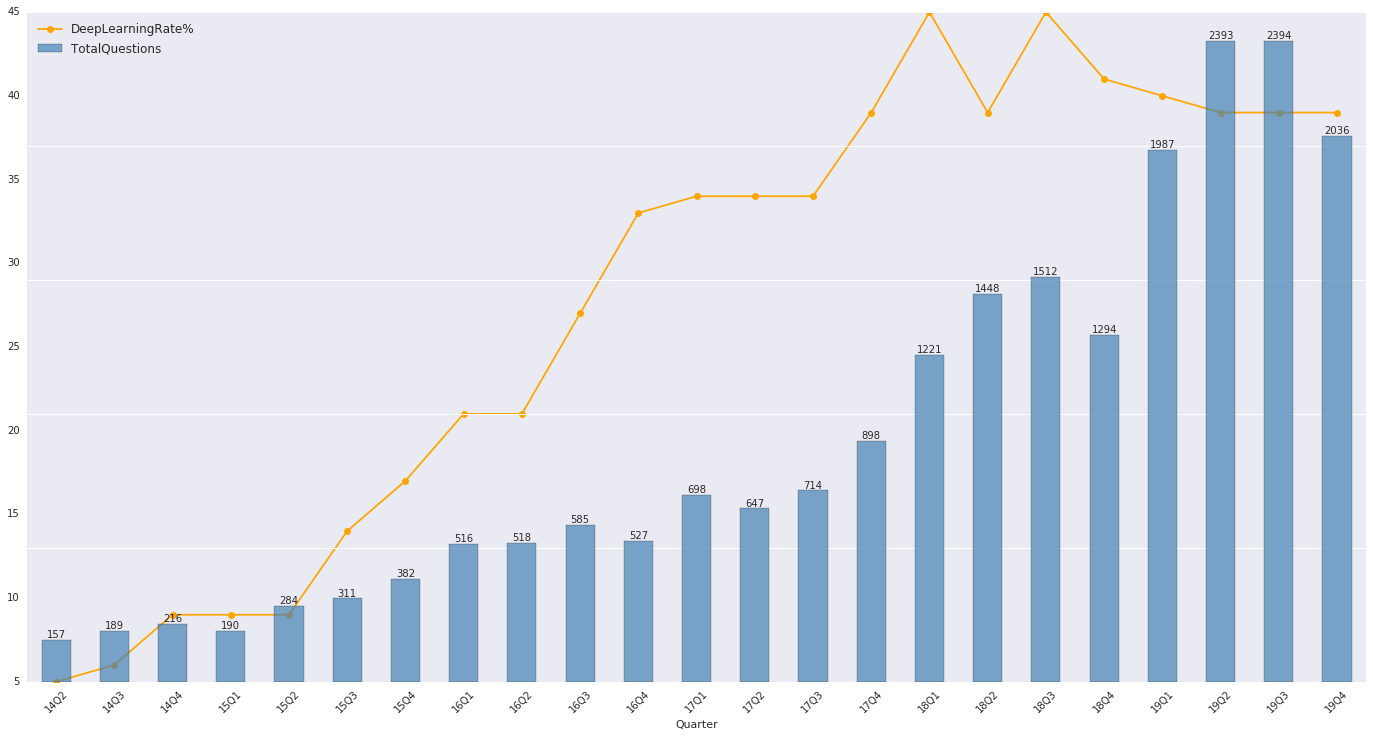

In [227]:
ax1 = quarterly.plot(kind="line", x="Quarter", y="DeepLearningRate%",
                     marker="o", color="orange", figsize=(24,12))

ax2 = quarterly.plot(kind="bar", x="Quarter", y="TotalQuestions", color="steelblue",
                    ax=ax1, secondary_y=True, alpha=0.7, rot=45)
#bar labels
for bars, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(bars, t, t, ha="center", va="bottom")

xlims = ax1.get_xlim()

#creating legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2,
          loc="upper left", prop={"size": 12})

for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)
        

After we visialised the data it is now more clear that there is a significant increase from 2015 onwards in the deep learning questions. Surge in these question has increased from 10% of the total questions to almost 30 - and even 40% by the end of time period show or end of 2018.

Based on the facts we can conclude that we will prepare a learning content which includes Deel learning question